In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/ITU_AI_5G/codes')

In [ ]:
data_dir = "/content/gdrive/My Drive/ITU_AI_5G/codes/baseline_data/"  ### training data path
data_dir2 = "/content/gdrive/My Drive/ITU_AI_5G/baseline_data/"    ### test data path
fun_PATH = "/content/gdrive/My Drive/ITU_AI_5G/codes"


In [ ]:
args_input = 'coord'
mm = 1

In [ ]:

import csv
import tensorflow as tf
from tensorflow.python.keras import metrics
from tensorflow.python.keras.models import model_from_json,Model
from tensorflow.python.keras.layers import Dense,concatenate
from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta,Adam
from sklearn.model_selection import train_test_split
from ModelHandler import ModelHandler
import numpy as np
import argparse


###############################################################################
# Support functions
###############################################################################


#For description about top-k, including the explanation on how they treat ties (which can be misleading
#if your classifier is outputting a lot of ties (e.g. all 0's will lead to high top-k)

#https://www.tensorflow.org/api_docs/python/tf/nn/in_top_k


def top_10_accuracy(y_true,y_pred):
    return metrics.top_k_categorical_accuracy(y_true,y_pred,k=10)

def top_50_accuracy(y_true,y_pred):
    return metrics.top_k_categorical_accuracy(y_true,y_pred,k=5)

def sub2ind(array_shape, rows, cols):
    ind = rows*array_shape[1] + cols
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    return ind

def ind2sub(array_shape, ind):
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    rows = (ind.astype('int') / array_shape[1])
    cols = ind % array_shape[1]
    return (rows, cols)

def beamsLogScale(y,thresholdBelowMax):
        y_shape = y.shape
        
        for i in range(0,y_shape[0]):            
            thisOutputs = y[i,:]
            logOut = 20*np.log10(thisOutputs + 1e-30)
            minValue = np.amax(logOut) - thresholdBelowMax
            zeroedValueIndices = logOut < minValue
            thisOutputs[zeroedValueIndices]=0
            thisOutputs = thisOutputs / sum(thisOutputs)
            y[i,:] = thisOutputs
        
        return y

def getBeamOutput(output_file):
    
    thresholdBelowMax = 6
    
    print("Reading dataset...", output_file)
    output_cache_file = np.load(output_file)
    yMatrix = output_cache_file['output_classification']
    
    yMatrix = np.abs(yMatrix)
    yMatrix /= np.max(yMatrix)
    yMatrixShape = yMatrix.shape
    num_classes = yMatrix.shape[1] * yMatrix.shape[2]
    
    y = yMatrix.reshape(yMatrix.shape[0],num_classes)
    y = beamsLogScale(y,thresholdBelowMax)
    print('y',y[0],y.shape)
    
    return y,num_classes



if args_input == 'coord': 
    ###############################################################################
    # Coordinate configuration
    #train
    coord_train_input_file = data_dir+'coord_input/coord_train.npz'
    coord_train_cache_file = np.load(coord_train_input_file)
    X_coord_train = coord_train_cache_file['coordinates']
    #validation
    coord_validation_input_file = data_dir2+'coord_input/coord_test.npz'
    coord_validation_cache_file = np.load(coord_validation_input_file)
    X_coord_validation = coord_validation_cache_file['coordinates']

    coord_train_input_shape = X_coord_train.shape



###############################################################################
# Output configuration
#train
output_train_file = data_dir+'beam_output/beams_output_train.npz'
y_train,num_classes = getBeamOutput(output_train_file)

output_validation_file = data_dir2+'beam_output/beams_output_test.npz'
y_validation, _ = getBeamOutput(output_validation_file)

##############################################################################
# Model configuration
##############################################################################

#multimodal
multimodal = mm

num_epochs = 300  ##
batch_size = 32  ## 64
validationFraction = 0.3 #from 0 to 1
modelHand = ModelHandler()
opt = Adam()

if args_input == 'coord': 
    print(X_coord_train)
    #print(coord_train_input_shape.shape)
    coord_model = modelHand.createArchitecture('coord_mlp',num_classes,[coord_train_input_shape[1]],'complete')
if args_input == 'coord':
    model = coord_model
    model.compile(loss=categorical_crossentropy,
                        optimizer=opt,
                        metrics=[metrics.categorical_accuracy, metrics.top_k_categorical_accuracy,top_50_accuracy])
    model.summary()
    hist = model.fit(X_coord_train,y_train, 
    validation_data=(X_coord_validation, y_validation),epochs=num_epochs,batch_size=batch_size)


Reading dataset... /content/gdrive/My Drive/ITU_AI_5G/codes/baseline_data/beam_output/beams_output_train.npz
y [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0. 

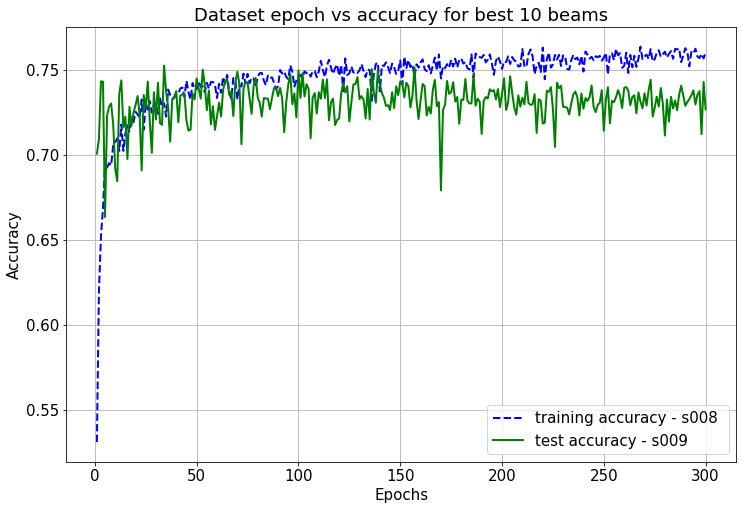

In [ ]:
import matplotlib.pyplot as plt


import matplotlib     
matplotlib.rcParams.update({'font.size': 15})

acc = hist.history['top_k_categorical_accuracy']
val_acc = hist.history['val_top_k_categorical_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc)+1)

# plt.plot()
plt.figure(figsize = (12,8))
plt.title('Dataset epoch vs accuracy for best 10 beams')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'b--', label='training accuracy - s008 ', linewidth=2)
plt.plot(epochs, val_acc, 'g-', label='test accuracy - s009',linewidth=2)
plt.legend()
plt.grid(True)
plt.show()


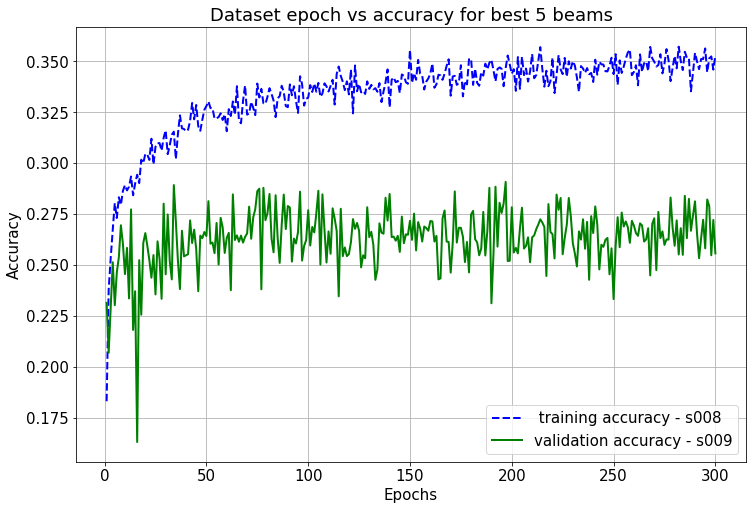

In [ ]:
import matplotlib.pyplot as plt


import matplotlib     
matplotlib.rcParams.update({'font.size': 15})

acc = hist.history['categorical_accuracy']
val_acc = hist.history['val_categorical_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc)+1)

plt.figure(figsize = (12,8))
plt.title('Dataset epoch vs accuracy for best 5 beams')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'b--', label=' training accuracy - s008', linewidth=2)
plt.plot(epochs, val_acc, 'g-', label='validation accuracy - s009',linewidth=2)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
Res = model.predict(X_coord_validation)

In [ ]:
len(Res)

9638

In [ ]:
len(Res[0])

256

In [ ]:
import pandas as pd
from google.colab import files

df = pd.DataFrame(Res) 
  
# saving the dataframe 
df.to_csv('Output.csv') 
files.download('Output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
/content/Output.csv